# Gut Meal Suggestion by using Gradient Bossted Trees

In this project, we aim to generate personalized meal plan recommendations using a dataset that combines gut microbiome profiles, dietary intake patterns, demographic information, and allergy indicators. The goal is to provide nutrition guidance tailored to individual health profiles.

Having already built and evaluated a Decision Tree classifier, we now extend our modeling to **Gradient-Boosted Trees** — a more advanced ensemble method that builds a series of decision trees, where each new tree focuses on correcting the errors of the previous one.

We expect the GBT model to outperform the standalone Decision Tree in terms of prediction accuracy and generalization, especially because:

GBT reduces overfitting by aggregating many weak learners.
It captures complex patterns and interactions in the data more effectively.
GBT is well-suited for imbalanced or noisy datasets, which we’ve addressed through preprocessing.

## Initial Set-up

In [0]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, expr, count
from pyspark.ml.feature import StringIndexer, VectorAssembler, QuantileDiscretizer, IndexToString
from pyspark.ml.classification import GBTClassifier, OneVsRest 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [0]:
#Initializing a session for gradient boosting
spark = SparkSession.builder.appName("GradientBoostingMealPlan").getOrCreate()

In [0]:
#import data
df = spark.read.csv("/FileStore/tables/microbe_gut_health_data_2.csv", header=True, inferSchema=True)

In [0]:
#saving the dataframe as a table
df.write.mode("overwrite").saveAsTable("gut_data")

## **EDA**

What is the minimum, and maximum age of the participants

In [0]:
%sql
SELECT 
  MIN(Age) AS min_age,
  MAX(Age) AS max_age,
  AVG(Age) AS avg_age,
  PERCENTILE(Age, 0.5) AS median_age
FROM gut_data;

min_age,max_age,avg_age,median_age
20,69,44.243,44.0


Participants are aged between 20 and 69.

In [0]:
%sql
SELECT 
  CASE 
    WHEN Age < 20 THEN 'Under 20'
    WHEN Age BETWEEN 20 AND 29 THEN '20–29'
    WHEN Age BETWEEN 30 AND 39 THEN '30–39'
    WHEN Age BETWEEN 40 AND 49 THEN '40–49'
    WHEN Age >= 50 THEN '50+'
  END AS age_group,
  COUNT(*) AS count
FROM gut_data
GROUP BY age_group
ORDER BY count DESC;


age_group,count
50+,395
20–29,225
30–39,200
40–49,180


Databricks visualization. Run in Databricks to view.

There is an almost balanced distribution among the age groups in the data.

Are there any nulls in the data?

In [0]:
%sql
SELECT
  SUM(CASE WHEN Age IS NULL THEN 1 ELSE 0 END) AS null_age,
  SUM(CASE WHEN BMI IS NULL THEN 1 ELSE 0 END) AS null_bmi,
  SUM(CASE WHEN Gender IS NULL THEN 1 ELSE 0 END) AS null_gender,
  SUM(CASE WHEN Bacteroides IS NULL THEN 1 ELSE 0 END) AS null_bacteroides,
  SUM(CASE WHEN Suggested_Meal_Plan IS NULL THEN 1 ELSE 0 END) AS null_meal_plan
FROM gut_data;


null_age,null_bmi,null_gender,null_bacteroides,null_meal_plan
0,0,0,0,0


The data seems to have no nulls, but we can fill na for good measure, and to ensure we have an unhindered model execution.

What is the distribution of data among the target classes?

In [0]:
%sql
SELECT Suggested_Meal_Plan, COUNT(*) AS count
FROM gut_data
GROUP BY Suggested_Meal_Plan
ORDER BY count DESC;

Suggested_Meal_Plan,count
Keto-Friendly Low-Sugar Plan,441
Gut-Health Fiber Boost,285
Metabolic Maintenance Diet,198
Mediterranean Gut Balance,64
Dairy-Free Anti-Inflammation Plan,6
Digestive Relief (Low-FODMAP),4
Heart Health Plus,2


Databricks visualization. Run in Databricks to view.

The data seems to highly unbalanced, skewed towards Keto Friendly Low-Sugar Plan.

**This will cause a bias towards the majority classes**

### Data Preparation

**The data is imbalanced on the suggested meal plans.** As this is the distribution:

Keto-Friendly Low-Sugar Plan	441

Gut-Health Fiber Boost	285

Metabolic Maintenance Diet	198

Mediterranean Gut Balance	64

Dairy-Free Anti-Inflammation Plan	6

Digestive Relief (Low-FODMAP)	4

Heart Health Plus	2

To effectively support our analysis, the data needs to be balanced on the target label, which in out case is Suggested Meal Plan

**One of the effective methods to balance our data would be to upscale the data i.e add similar data synthetically.However, a drawback of this method is that we induce duplcate data that could overfit over model.**

A possible workaround, would be to merge these classes in to a broader class, that could balance the data.

In [0]:
from pyspark.sql.functions import when, col

# Define the classes to merge
classes_to_merge = [
    "Mediterranean Gut Balance",
    "Heart Health Plus",
    "Dairy-Free Anti-Inflammation Plan",
    "Digestive Relief (Low-FODMAP)"
]

# Create a new column with merged class name
df = df.withColumn(
    "Meal_Plan_Combined",
    when(col("Suggested_Meal_Plan").isin(classes_to_merge), "Balanced Wellness Plan")
    .otherwise(col("Suggested_Meal_Plan"))
)


In [0]:
#creating a new table for the data with the new merged class
df.write.mode("overwrite").saveAsTable("new_gut_data")

In [0]:
%sql
select Meal_Plan_Combined, count(*) as Count
from new_gut_data
group by Meal_Plan_Combined
order by Count desc

Meal_Plan_Combined,Count
Keto-Friendly Low-Sugar Plan,441
Gut-Health Fiber Boost,285
Metabolic Maintenance Diet,198
Balanced Wellness Plan,76


Databricks visualization. Run in Databricks to view.

**Even after the merging the classes with low records into a new class called _Balanced Wellness Plan_, we can still obeserve a disparity among the classes. However, we can still upscale the new class, to balance the data.**

This might lead our model to overfit, but choosing the right upscale limit for the class might avoid overfitting and bias at the same time.

In [0]:
# Target count for balanced representation
#target_count = 150
target_count = 200
#target_count = 250

from pyspark.sql.functions import col, rand

# Filter and upsample the Balanced Wellness Plan
bwp_df = df.filter(col("Meal_Plan_Combined") == "Balanced Wellness Plan")
factor = int(target_count / bwp_df.count()) + 1

bwp_upsampled = (
    bwp_df.withColumn("rand", rand())
    .sample(withReplacement=True, fraction=float(factor), seed=42)
    .drop("rand")
    .limit(target_count)
)

# Keep all other classes as-is
others_df = df.filter(col("Meal_Plan_Combined") != "Balanced Wellness Plan")

# Combine the final balanced dataset
df_balanced = others_df.union(bwp_upsampled)

# Check new distribution
df_balanced.groupBy("Meal_Plan_Combined").count().orderBy("count", ascending=False).display()


Meal_Plan_Combined,count
Keto-Friendly Low-Sugar Plan,441
Gut-Health Fiber Boost,285
Balanced Wellness Plan,200
Metabolic Maintenance Diet,198


Databricks visualization. Run in Databricks to view.

Indexing the categorical features to support model training.

In [0]:
# String Indexing
indexers = [
    StringIndexer(inputCol="Gender", outputCol="Gender_Idx").fit(df_balanced),
    StringIndexer(inputCol="Meal_Plan_Combined", outputCol="Meal_Plan_Idx").fit(df_balanced)
]
for idx in indexers:
    df_balanced = idx.transform(df_balanced)


In [0]:
nutrients = ["Protein_Intake", "Fiber_Intake", "Carbohydrate_Intake", "Fat_Intake"]
for col_name in nutrients:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_Idx").fit(df_balanced)
    #The 'StringIndexer' converted the categories of High,Medium and Low in the fields to indexes 0,1 and 2
    df_balanced = indexer.transform(df_balanced)


## **Feature Selection**

For Categorical Data (Chi Square Test)

In [0]:
from pyspark.ml.stat import ChiSquareTest

# Categorical / Indexed / Binary features only
cat_features = [
    "Protein_Intake_Idx", "Fiber_Intake_Idx", "Carbohydrate_Intake_Idx", "Fat_Intake_Idx",
    "Gender_Idx", "Dairy_Allergy", "Gluten_Allergy", "Nut_Allergy"
]

# Assemble features
assembler = VectorAssembler(inputCols=cat_features, outputCol="categorical_features")
df_cat = assembler.transform(df_balanced)

# Run Chi-Square test using indexed label
chi_sq_result = ChiSquareTest.test(df_cat, featuresCol="categorical_features", labelCol="Meal_Plan_Idx")


In [0]:
result = chi_sq_result.collect()[0]

p_values = result["pValues"]
degrees_of_freedom = result["degreesOfFreedom"]
statistics = result["statistics"]

# Match to feature names
feature_names = [
    "Protein_Intake_Idx", "Fiber_Intake_Idx", "Carbohydrate_Intake_Idx", "Fat_Intake_Idx",
    "Gender_Idx", "Dairy_Allergy", "Gluten_Allergy", "Nut_Allergy"
]

# Create a readable DataFrame
import pandas as pd

chi_sq_table = pd.DataFrame({
    "Feature": feature_names,
    "ChiSq_Statistic": statistics,
    "Degrees_of_Freedom": degrees_of_freedom,
    "p-Value": p_values
})

# Sort by p-value if desired
chi_sq_table = chi_sq_table.sort_values(by="p-Value")

# Display the table
chi_sq_table.display()

Feature,ChiSq_Statistic,Degrees_of_Freedom,p-Value
Fiber_Intake_Idx,155.01354499941561,6,0.0
Carbohydrate_Intake_Idx,998.0724372457623,6,0.0
Dairy_Allergy,21.891868008624915,3,6.869921113006328E-5
Gluten_Allergy,6.095941618788309,3,0.10703462028014188
Protein_Intake_Idx,7.091871171405126,6,0.31243456247136125
Nut_Allergy,2.67144418243587,3,0.44510188879794677
Gender_Idx,1.5880507291835628,3,0.6621022616781982
Fat_Intake_Idx,3.8099879880239644,6,0.7023719439982611


Databricks visualization. Run in Databricks to view.

Chi Square test is performed to understand the statistical relationship between categorical features and the target feature.

According to the test Gluten allergy, Protein intake, nut allergy, gender, and fat intake are not a significant reason for determining a participants meal plan.

For continous Features

In [0]:
# Define numeric features
numeric_features = ["Age", "BMI", "Bacteroides", "Firmicutes", "Lactobacillus", "Proteobacteria","Actinobacteria","Verrucomicrobia"]




In [0]:
corr_matrix = pd.DataFrame(index=numeric_features, columns=numeric_features)

# Loop through feature pairs and calculate Pearson correlation
for f1 in numeric_features:
    for f2 in numeric_features:
        corr = df_balanced.stat.corr(f1, f2)
        corr_matrix.loc[f1, f2] = round(corr, 2)

# Convert all values to float for plotting
corr_matrix = corr_matrix.astype(float)

# Optional: display the matrix
corr_matrix.display()

Age,BMI,Bacteroides,Firmicutes,Lactobacillus,Proteobacteria,Actinobacteria,Verrucomicrobia
1.0,-0.05,-0.07,-0.06,-0.02,-0.06,0.01,-0.04
-0.05,1.0,-0.03,-0.07,0.05,0.03,0.04,-0.01
-0.07,-0.03,1.0,0.0,0.02,-0.02,-0.04,0.03
-0.06,-0.07,0.0,1.0,-0.01,-0.01,-0.05,0.03
-0.02,0.05,0.02,-0.01,1.0,0.03,0.04,0.0
-0.06,0.03,-0.02,-0.01,0.03,1.0,0.03,0.04
0.01,0.04,-0.04,-0.05,0.04,0.03,1.0,-0.04
-0.04,-0.01,0.03,0.03,0.0,0.04,-0.04,1.0


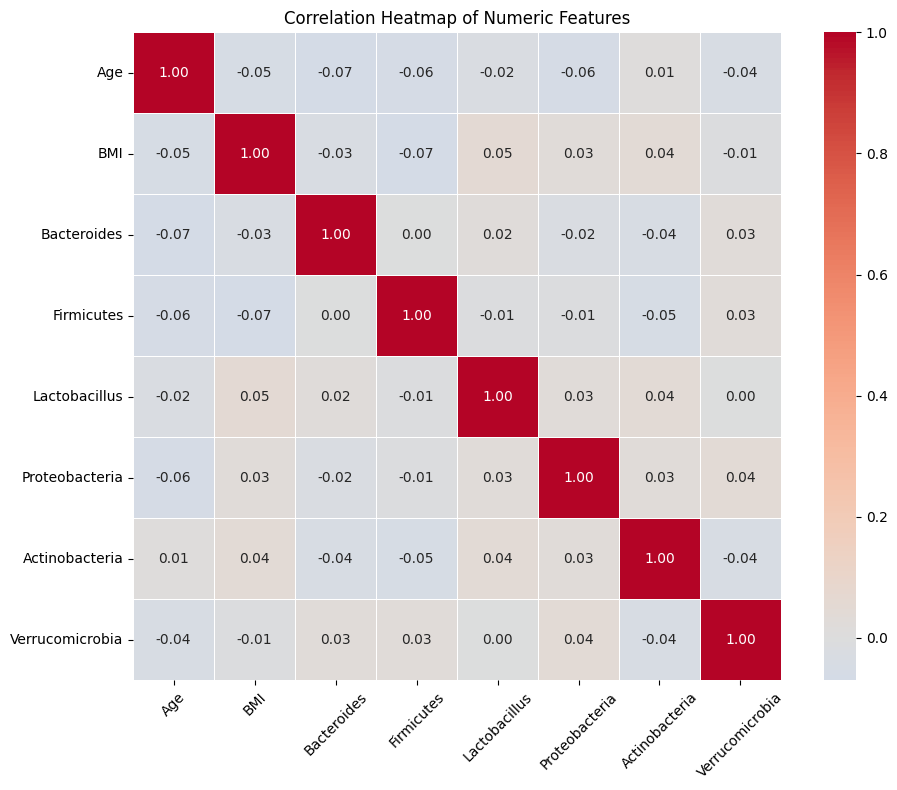

In [0]:
#Vizualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,             # shows correlation values
            cmap="coolwarm",        # diverging color map
            center=0,               # center of the color map is 0
            fmt=".2f",              # format for values
            linewidths=0.5,         # spacing between cells
            square=True             # keep cells square
           )
plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Low correlation between the features we opted for the analysis, indicating that each feature we selected contributes individually in deciding the meal plan, and absence of any redundancy.

However, there is an understandable correlationn between age and BMI, which can accredited to the general fact that as people grow older their BMIs may decrease.

## Features that could be ideal for gradient boosting:
- Bacteroides
- Firmicutes
- Lactobacillus
- Proteobacteria
- Actinobacteria
- Verrucomicrobia
- Age
- BMI
- Fiber_Intake
- Carbohydrate_Intake
- Dairy Allergy



## Gradient Trees Classifier

In [0]:
assembler = VectorAssembler(
    inputCols=[
        "Age", "BMI",
        "Fiber_Intake_Idx", "Carbohydrate_Intake_Idx",
        "Bacteroides", "Firmicutes", "Lactobacillus", "Proteobacteria", "Actinobacteria", "Verrucomicrobia",
         "Dairy_Allergy",
    ],
    outputCol="features"
)
df_balanced = assembler.transform(df_balanced)

In [0]:
# Train-Test Split
train, test = df_balanced.randomSplit([0.75, 0.25], seed= 13)

In [0]:
# Step 1: Initialize a Gradient-Boosted Trees (GBT) classifier.
# Note: GBTClassifier in PySpark only supports binary classification by default.
# We use 'features' as input features and 'Meal_Plan_Idx' as the target label.
gbt = GBTClassifier(featuresCol="features", labelCol="Meal_Plan_Idx", maxIter=20)
# Step 2: Wrap the GBT classifier in a OneVsRest strategy.
# This allows GBT to be used for multi-class classification by training one binary classifier per class.
ovr = OneVsRest(classifier=gbt, labelCol="Meal_Plan_Idx", featuresCol="features")
# Step 3: Train the OneVsRest model using the training dataset.
model = ovr.fit(train)
# Step 4: Use the trained model to make predictions on the test dataset.
preds = model.transform(test)

### Evaluating the model

**Accuracy**

In [0]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="Meal_Plan_Idx",
    predictionCol="prediction",
    metricName="accuracy"
)

acc = evaluator.evaluate(preds)
print(f"GBT Accuracy: {acc:.4f}")

GBT Accuracy: 0.9480


**F1 Score**

In [0]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Meal_Plan_Idx",
    predictionCol="prediction",
    metricName="f1"
)

f1_score = f1_evaluator.evaluate(preds)
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.9483


**Precision and Recall**

In [0]:
precision = MulticlassClassificationEvaluator(
    labelCol="Meal_Plan_Idx",
    predictionCol="prediction",
    metricName="weightedPrecision"
).evaluate(preds)

recall = MulticlassClassificationEvaluator(
    labelCol="Meal_Plan_Idx",
    predictionCol="prediction",
    metricName="weightedRecall"
).evaluate(preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.9523
Recall: 0.9480


**Understanding the outcome of the model**

In [0]:
#save the prediciton data as a table for querying
preds.write.mode("overwrite").saveAsTable("GBT_predictions")

In [0]:
#Query to check the count of True predictions
spark.sql("select Meal_Plan_Idx,Meal_Plan_Combined As Actual_Meal_Plan,prediction as Predicted_Idx, count(*) as Count,\
        case when Meal_Plan_Idx = prediction then 'True_Postive'\
        else  'Misclassification'\
        end as Classification_Result\
        from GBT_predictions\
        group by Meal_Plan_Combined,Meal_Plan_Idx,prediction\
        order by Count desc").display()

Meal_Plan_Idx,Actual_Meal_Plan,Predicted_Idx,Count,Classification_Result
0.0,Keto-Friendly Low-Sugar Plan,0.0,102,True_Postive
1.0,Gut-Health Fiber Boost,1.0,70,True_Postive
2.0,Balanced Wellness Plan,2.0,46,True_Postive
3.0,Metabolic Maintenance Diet,3.0,37,True_Postive
2.0,Balanced Wellness Plan,3.0,9,Misclassification
1.0,Gut-Health Fiber Boost,2.0,3,Misclassification
1.0,Gut-Health Fiber Boost,0.0,1,Misclassification
3.0,Metabolic Maintenance Diet,1.0,1,Misclassification


Databricks visualization. Run in Databricks to view.

**True Positives**

In [0]:
#Query to check the count of True predictions
spark.sql("select Meal_Plan_Idx as Actual_Idx,Meal_Plan_Combined,prediction as Predicted_Idx, count(*) as Count\
        from GBT_predictions\
        where Meal_Plan_Idx = prediction \
        group by Meal_Plan_Combined,Meal_Plan_Idx,prediction\
        order by Count desc").display()

Actual_Idx,Meal_Plan_Combined,Predicted_Idx,Count
0.0,Keto-Friendly Low-Sugar Plan,0.0,102
1.0,Gut-Health Fiber Boost,1.0,70
2.0,Balanced Wellness Plan,2.0,46
3.0,Metabolic Maintenance Diet,3.0,37


Databricks visualization. Run in Databricks to view.

**Misclassifications by the model**

In [0]:
#Query to check the count of failed predictions
spark.sql("select Meal_Plan_Idx as Actual_Idx,Meal_Plan_Combined,prediction as Predicted_Idx, count(*) as Count\
        from GBT_predictions\
        where Meal_Plan_Idx != prediction \
        group by Meal_Plan_Combined,Meal_Plan_Idx,prediction\
        order by Count desc").display()

Actual_Idx,Meal_Plan_Combined,Predicted_Idx,Count
2.0,Balanced Wellness Plan,3.0,9
1.0,Gut-Health Fiber Boost,2.0,3
1.0,Gut-Health Fiber Boost,0.0,1
3.0,Metabolic Maintenance Diet,1.0,1


Databricks visualization. Run in Databricks to view.

**Interpretation:**

The Gradient Bossted Trees model that I build is performing well. It was extremely accurate in predicting Keto_Friendly Keto Diet. It made only few misclassified predictions for Gut Health Fiber Boost and Metabolic Maintenance Diet. For instance, it suggested a participant to follow Gut Health Boost Meal, while the actual meal plan should have been Metabolic Maintenance Diet. However, as it is just a single occurence, it could indicate the participants health markers are an outlier. Additional markers or indicators could have fixed this.

The model failed the highest to accurately predict Balanced Wellness Plan, this could be attributed to the fact that this class is a combination of multiple classes. These misclassifications to Metabolic Maintenance Plan, could be because of overlapping indicator among the different classes in Balance Wellness Plan and the Metabolic Maintenance Plan.

## Conclusion

The Gradient-Boosted Trees (GBT) model we developed—leveraging decision trees to recommend personalized meal plans based on individuals' nutrient intake, microbiome indicators, and demographic attributes—demonstrated strong and consistent predictive performance. It was effective in assigning appropriate meal plans across a wide range of user profiles, suggesting it can be a reliable tool for personalized dietary recommendations.

However, it’s important to recognize a key limitation: the underlying dataset was imbalanced, meaning some meal plan categories had far fewer examples than others. Even with techniques like merging and upsampling underrepresented classes, there’s a risk that the model may still favor majority classes and perform less accurately on rarer meal plan types. Additionally, high performance metrics on the training or internal validation data could indicate overfitting, where the model learns patterns specific to the current data but may not generalize well to new or more diverse populations. Therefore, caution is warranted before deploying the model broadly, and it should be further validated on external, balanced datasets to ensure consistent and fair performance.

**Clinical and Business Viability**

The GBT model’s strong performance, especially on common meal plan categories, indicates real potential for use in both clinical nutrition guidance and commercial wellness platforms. Clinically, the model’s alignment with microbiome science—such as recommending fiber-rich plans for dysbiotic profiles—supports its utility in metabolic and gut-health management.

From a business perspective, the integration of microbiome data offers a valuable differentiator for personalization in mainstream health apps. However, niche plans like Low-FODMAP part of the Balance Meal Plan broader class remain underrepresented due to class imbalance. While merging and upsampling strategies improved this, further data enrichment and external validation are essential for scaling the model across diverse user bases and use cases.

**In summary,** the GBT model balances clinical logic with business readiness, and with continued refinement and validation, it holds strong potential for real-world application in both healthcare and wellness markets.